# Pôle DATA – Test technique - Complété par Stuart Yoël TURNER
## Décorrélation des effets environnementaux sur les mesures d’un capteur

### Problématique :
Le fichier dataset.dat contient les mesures d’un capteur de déplacement en fonction du temps ainsi que les mesures de température et d’ensoleillement associées. L’objectif de l’exercice est de fournir les valeurs de déplacement décorrélées (c’est-à-dire ne dépendant plus de la température et de l’ensoleillement) aux mêmes pas de temps.


### Remarques :
Le sujet est un problème ouvert. Il n’est pas demandé au candidat une solution complète. Le candidat pourra se pencher sur les questions suivantes :
- Lecture, nettoyage et affichage des données.
- Étude qualitative et quantitative des corrélations.
- Choix et implémentation d’un algorithme de décorrélation.
- Affichage et enregistrement des résultats.
- Automatisation et généralisation de la solution


In [655]:
# Importing relevant modules
import pandas as pd # To manipulate & visualize data
import numpy as np # To manipulate the data mathematically
from scipy import linalg # To apply the linear model for decorrelation
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For visualization

In [656]:
# Reading the data file
df = pd.read_csv('dataset.dat', delimiter = ',')
df

,TIMESTAMP,deplacement,ensoleillement,temperature
0,2020-03-14 00:01:22,1.3,0.0,8.381906
1,2020-03-14 00:18:05,0.5,0.0,8.388235
2,2020-03-14 00:35:17,1.8,0.0,8.397227
3,2020-03-14 00:52:39,NAN,0.0,8.411952
4,2020-03-14 01:09:27,1.7,0.0,8.426197
...,...,...,...,...
1843,2020-04-06 04:53:10,2.0,0.0,13.979392
1844,2020-04-06 05:11:04,2.1,0.0,13.866014
1845,2020-04-06 05:28:55,2.4,0.0,13.752952
1846,2020-04-06 05:46:51,2.2,0.0,13.772561


In [657]:
# Cleaning the data (dropping rows containing NAN values)
df = df.replace(to_replace='NAN', value=np.nan)
df = df.dropna(axis=0, how='any')
df.head()

,TIMESTAMP,deplacement,ensoleillement,temperature
0,2020-03-14 00:01:22,1.3,0.0,8.381906
1,2020-03-14 00:18:05,0.5,0.0,8.388235
2,2020-03-14 00:35:17,1.8,0.0,8.397227
4,2020-03-14 01:09:27,1.7,0.0,8.426197
5,2020-03-14 01:26:24,1.7,0.0,8.440569


In [658]:
# Put the features into a numpy array
df_array = df.to_numpy()
features = df_array[:,1:4]
print("Arrayed features: \n", features, "\n")

# Ensure that the data is of type float and rearrange the features in rows
features = features.astype(float) 
features = features.T
print("Corrected arrayed features: \n", features, "\n")

# deplacement = features[0,:]
# ensoleillement = features[1,:]
# temperature = features[2,:]

Arrayed features: 
 [['1.3' 0.0 8.381905942777777]
 ['0.5' 0.0 8.388235151388889]
 ['1.8' 0.0 8.397226738333334]
 ...
 ['2.4' 0.0 13.752951833333332]
 ['2.2' 0.0 13.77256135]
 ['2.5' 0.0 13.800786983333333]] 

Corrected arrayed features: 
 [[ 1.3         0.5         1.8        ...  2.4         2.2
   2.5       ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 8.38190594  8.38823515  8.39722674 ... 13.75295183 13.77256135
  13.80078698]] 



In [659]:
# Normalizing each features for fair comparison during PCA & ZCA
features_mean = np.array(np.mean(features, axis=1), ndmin=2).T
print("Features' mean: \n", features_mean, "\n")

features_std = np.array(np.std(features, axis=1), ndmin=2).T
print("Features' standard deviation: \n", features_std, "\n")

features_normalized = (features - features_mean)/features_std
print("Normalized features: \n", features_normalized, "\n")

Features' mean: 
 [[ -0.30369108]
 [250.19868129]
 [ 10.25697254]] 

Features' standard deviation: 
 [[  2.63899319]
 [371.32084005]
 [  4.85979732]] 

Normalized features: 
 [[ 0.6076905   0.30454458  0.79715669 ...  1.02451613  0.94872965
   1.06240937]
 [-0.67380727 -0.67380727 -0.67380727 ... -0.67380727 -0.67380727
  -0.67380727]
 [-0.38583226 -0.3845299  -0.3826797  ...  0.7193673   0.72340235
   0.72921034]] 



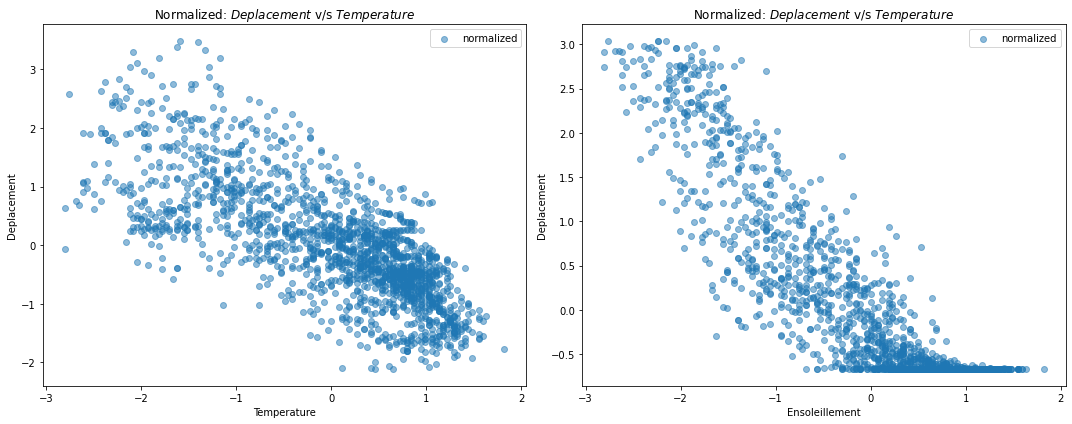

In [660]:
# Plotting relationships (covariance) betweeen features
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].scatter(features_normalized[0,:], features_normalized[2,:], label='normalized', alpha=0.5)
axs[0].set_title('Normalized: $Deplacement$ v/s $Temperature$')
axs[0].set(xlabel='Temperature', ylabel='Deplacement')
axs[0].legend()

axs[1].scatter(features_normalized[0,:], features_normalized[1,:], label='normalized', alpha=0.5)
axs[1].set_title('Normalized: $Deplacement$ v/s $Temperature$')
axs[1].set(xlabel='Ensoleillement', ylabel='Deplacement')
axs[1].legend()

fig.tight_layout()
plt.show()

Covariance matrix of correlated features :



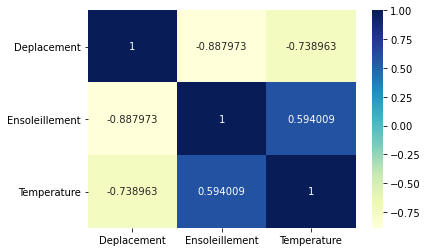

In [661]:
# Covariance matrix of the features
sigma = np.cov(features_normalized, rowvar=True, bias=True)
print("Covariance matrix of correlated features :\n")

labs = ['Deplacement', 'Ensoleillement', 'Temperature']

sns.heatmap(sigma, annot=True, fmt='g', xticklabels=labs, yticklabels=labs, cmap='YlGnBu')
plt.show()

In [662]:
# Computing the eigenvalues & vectors of the covariance matrix
w, v = linalg.eig(sigma)
print("Eigenvalues of covariance matrix:\n",w.real.round(4),"\n")
print("Eigenvectors of covariance matrix:\n",v.real.round(4),"\n")

# Computing the eigenvalues diagonal matrix (Lambda)
epsilon = 1e-5 # To prevent division by zero
diagw = np.diag(1/(w**0.5 + epsilon))
print("Diagonal matrix (Lambda): \n", diagw.real.round(4), "\n")

Eigenvalues of covariance matrix:
 [2.4871 0.087  0.4259] 

Eigenvectors of covariance matrix:
 [[ 0.6129 -0.7688  0.1823]
 [-0.5802 -0.5946 -0.5566]
 [-0.5363 -0.2354  0.8105]] 

Diagonal matrix (Lambda): 
 [[0.6341 0.     0.    ]
 [0.     3.3903 0.    ]
 [0.     0.     1.5324]] 



### Applying ZCA & PCA algorithm
$
\begin{align}
W_{PCA} &=\Lambda^{\frac{-1}{2}}\ U^T\ X \tag{1} \\
W_{ZCA} &= U\ \Lambda^{\frac{-1}{2}}\ U^T\ X \tag{2} \\
\end{align}
$

$\mathrm{\Lambda}:Matrix\ of\ eigenvalues\ of\ covariance\ matrix\$

$U:matrix\ of\ eigenvectors\ of\ covariance\ matrix$

$X:matrix\ of\ data\ with\ each\ row\ as\ a\ feature$

In [663]:
# Applying ZCA & PCA algorithm
features_rotated = np.dot(v, features_normalized)
features_pca = np.dot(np.dot(diagw, v.T), features_normalized)
features_zca = np.dot(np.dot(np.dot(v, diagw), v.T), features_normalized)

Covariance matrix of uncorrelated features:



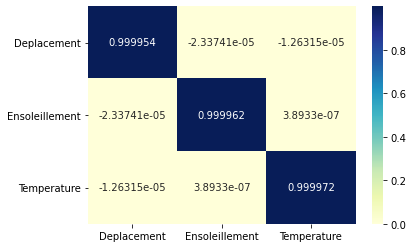

In [664]:
# Checking the new covariance of decorrelated features
sigma = np.cov(features_zca.real, rowvar=True, bias=True)
print("Covariance matrix of uncorrelated features:\n")

labs = ['Deplacement', 'Ensoleillement', 'Temperature']

sns.heatmap(sigma, annot=True, fmt='g', xticklabels=labs, yticklabels=labs, cmap='YlGnBu')
plt.show()

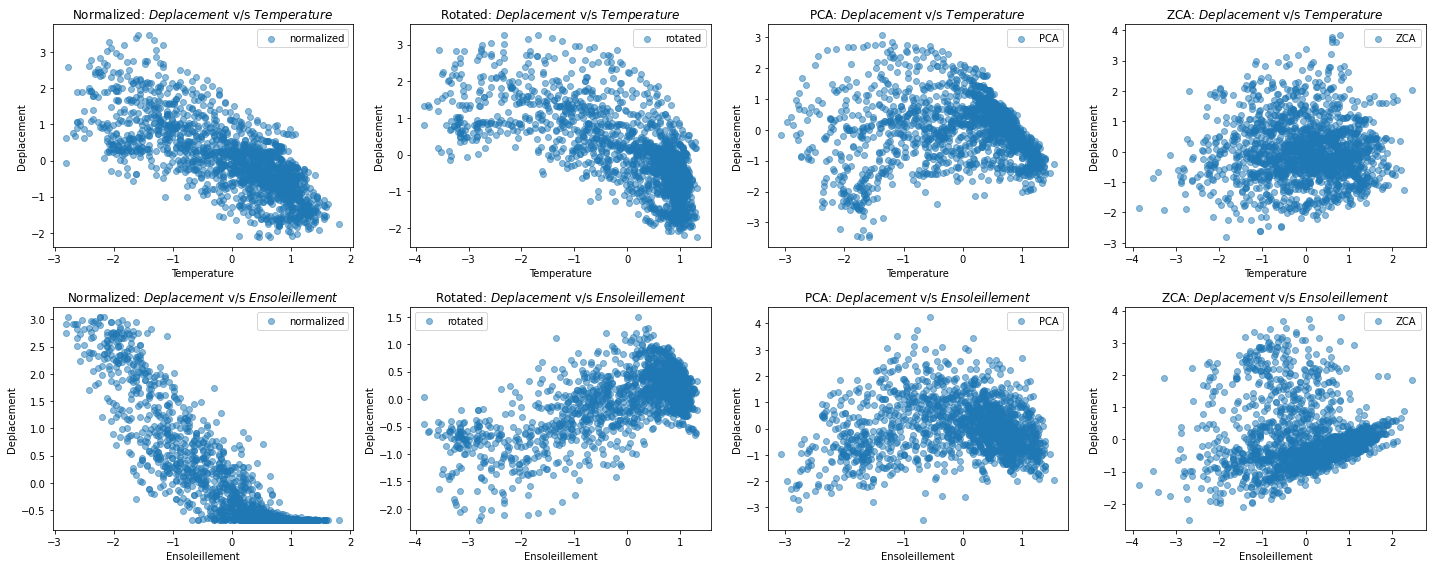

In [665]:
# Plotting of results
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

axs[0,0].scatter(features_normalized[0,:], features_normalized[2,:], label='normalized', alpha=0.5)
axs[0,0].set_title('Normalized: $Deplacement$ v/s $Temperature$')

axs[0,1].scatter(features_rotated[0,:], features_rotated[2,:], label='rotated', alpha=0.5)
axs[0,1].set_title('Rotated: $Deplacement$ v/s $Temperature$')

axs[0,2].scatter(features_pca[0,:].real, features_pca[2,:].real, label='PCA', alpha=0.5)
axs[0,2].set_title('PCA: $Deplacement$ v/s $Temperature$')

axs[0,3].scatter(features_zca[0,:].real, features_zca[2,:].real, label='ZCA', alpha=0.5)
axs[0,3].set_title('ZCA: $Deplacement$ v/s $Temperature$')

axs[1,0].scatter(features_normalized[0,:], features_normalized[1,:], label='normalized', alpha=0.5)
axs[1,0].set_title('Normalized: $Deplacement$ v/s $Ensoleillement$')

axs[1,1].scatter(features_rotated[0,:], features_rotated[1,:], label='rotated', alpha=0.5)
axs[1,1].set_title('Rotated: $Deplacement$ v/s $Ensoleillement$')

axs[1,2].scatter(features_pca[0,:].real, features_pca[1,:].real, label='PCA', alpha=0.5)
axs[1,2].set_title('PCA: $Deplacement$ v/s $Ensoleillement$')

axs[1,3].scatter(features_zca[0,:].real, features_zca[1,:].real, label='ZCA', alpha=0.5)
axs[1,3].set_title('ZCA: $Deplacement$ v/s $Ensoleillement$')

i = 1
for ax in axs.flat:
    if i < 5:
        ax.set(xlabel='Temperature', ylabel='Deplacement')
    else:
        ax.set(xlabel='Ensoleillement', ylabel='Deplacement')
    i += 1
    ax.legend()
    
fig.tight_layout()
plt.show()

In [666]:
# Rescaling the features
features_decorrelated = (features_zca.real*features_std) + features_mean

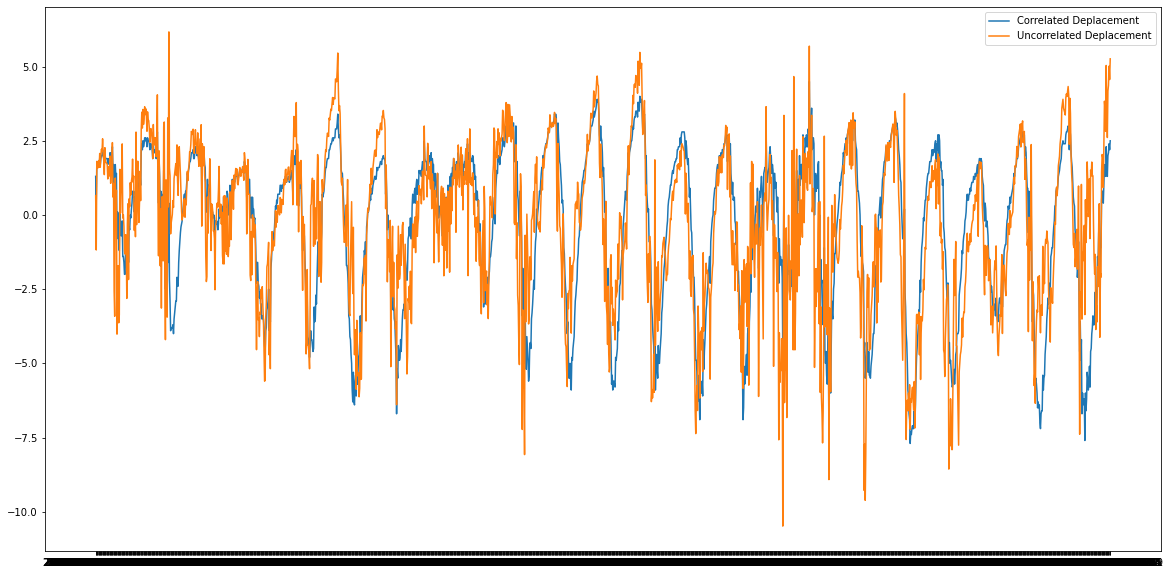

In [667]:
# Comparing the correlated & decorrelated deplacement
fig = plt.figure(figsize=(20,10))
plt.plot(df_array[:,0], features[0,:], label="Correlated Deplacement")
plt.plot(df_array[:,0], features_decorrelated[0,:], label="Uncorrelated Deplacement")
plt.legend()

In [668]:
# Generalization of the solution
def features_decorrelation(dataset, nfeat=3):
    """
    This function decorrelate the features of a dataset (time series)
    with the timestamp and features arranged in the following format
    in a csv file and returns the deccorelated features.
    
    INPUT: dataset in .csv format
           Number of features that present in the dataset (nfeat)
    
         TIMESTAMP            FEATURE1   FEATURE2    FEATURE3  ...
    2020-03-14 00:01:22         1.3        0.0       8.381906  ...
    2020-03-14 00:18:05         0.5        0.0       8.388235  ...
            ...                 ...        ...          ...    ...     
    
    OUTPUT: deccorelated features arranged in rows in a numpy array
    """
    
    import pandas as pd
    import numpy as np
    from scipy import linalg
    
    df = pd.read_csv(dataset, delimiter=',')
    # Should consider every possible errors in dataset for good generalization
    df = df.replace(to_replace='NAN', value=np.nan) 
    df = df.dropna(axis=0, how='any')    

    # Ensure that the data is of type float and rearrange the features in rows
    df_array = df.to_numpy()
    features = df_array[:,1:nfeat+1]
    features = features.astype(float) 
    features = features.T
    
    # Normalizing features
    features_mean = np.array(np.mean(features, axis=1), ndmin=2).T
    features_std = np.array(np.std(features, axis=1), ndmin=2).T
    features_normalized = (features - features_mean)/features_std
    
    # Covariance matrix of the features
    sigma = np.cov(features_normalized, rowvar=True, bias=True)
    
    # Computing the eigenvalues diagonal matrix (Lambda)
    w, v = linalg.eig(sigma)
    epsilon = 1e-5 # To prevent division by zero
    diagw = np.diag(1/(w**0.5 + epsilon))
    
    # Applying ZCA algorithm for decorrelation (More efficient than PCA)
    features_zca = np.dot(np.dot(np.dot(v, diagw), v.T), features_normalized)
    
    # Rescaling the features
    features_decorrelated = (features_zca.real*features_std) + features_mean
    
    return features_decorrelated


In [669]:
decor_feat = features_decorrelation('dataset.dat', nfeat=3)
decor_feat.shape

(3, 1761)

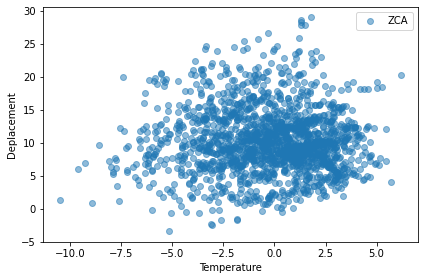

In [670]:
fig, ax = plt.subplots()
ax.scatter(decor_feat[0,:].real, decor_feat[2,:].real, label='ZCA', alpha=0.5)
ax.set(xlabel='Temperature', ylabel='Deplacement')
ax.legend() 
fig.tight_layout()
plt.show()

#### Questionnaire :
Pour faire progresser et améliorer l’expérience de recrutement, faites-nous vos retours en remplissant les questions suivantes :

1.	Comment jugez-vous la pertinence de ce test ? 
4 : Très pertinent

2.	Comment jugez-vous la difficulté de ce test ?
2 : Assez facile

3.	Combien de temps avez-vous pris pour réaliser le test ? 
Une demi-journée 